# Relative Reconstruction Error

In [2]:
import torch
import pytorch_lightning as pl
import numpy as np
from core.mesh_data import DataModule
from core.VCAE.model import Model

In [11]:
dm = DataModule(data_dir='../data/ignition_mesh',
                spatial_dim=2,
                num_points=9074,
                batch_size=128,
                channels=[1])

trainer = pl.Trainer(accelerator='gpu', devices=1, logger=False)

conv_params = {"in_channels":[1,16],
                "out_channels":[16,16],
                "kernel_size":[3],
                "bias":[False],
                "padding": ["same"]}

path = 'ignition/vcae_pool/version_0/checkpoints/epoch=3627.ckpt'
model = Model.load_from_checkpoint('../lightning_logs/'+path,
                                  data_info=dm.get_data_info(),
                                  conv_params=conv_params)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
out = trainer.test(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_avg_err          0.05885091423988342
      test_max_err          0.10330650210380554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Images/GIFs

In [4]:
import gif
import matplotlib.pyplot as plt

In [5]:
pred = trainer.predict(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

RuntimeError: The size of tensor a (25) must match the size of tensor b (50) at non-singleton dimension 1

In [9]:
pred[0].shape

torch.Size([512, 1, 2500])

In [10]:
dm.data_shape = [50,50]
pred = dm.agglomerate(pred)

RuntimeError: The size of tensor a (25) must match the size of tensor b (50) at non-singleton dimension 1

## Raw data

In [8]:
domain = 'ignition_square'
data_dir = f'data/{domain}/train.npy'

data = torch.from_numpy(np.float32(np.load(data_dir)))
data = data[...,1]

mean = torch.mean(data, dim=(0,1,2), keepdim=True)
stdv = torch.sqrt(torch.var(data, dim=(0,1,2), keepdim=True))
stdv = torch.max(stdv, torch.tensor(1e-3))

data = (data-mean)/stdv

raw = data/(torch.max(np.abs(data))+1e-4)

## Make GIF

In [9]:
@gif.frame
def plot(i):
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    
    ax[0].imshow(raw[i,:,:], vmin=-1, vmax=1, origin='lower')
    ax[0].set_title("Raw Data")
    
    ax[1].imshow(pred[i,:,:], vmin=-1, vmax=1, origin='lower')
    ax[1].set_title("Reconstructed")

In [10]:
block = [i for i in range(0, 250)]
frames = [plot(i) for i in block]    
gif.save(frames, f'train.gif', duration=100)

## Make Image

Text(0.5, 1.0, 'Reconstructed')

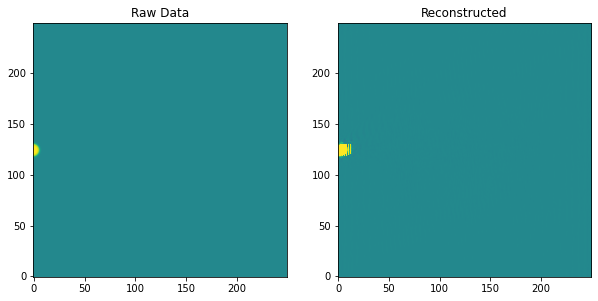

In [12]:
t = 0

fig, ax = plt.subplots(1, 2, figsize=(10,10))
    
ax[0].imshow(raw[t,:,:], vmin=-1, vmax=1, origin='lower')
ax[0].set_title("Raw Data")

ax[1].imshow(pred[t,:,:], vmin=-1, vmax=1, origin='lower')
ax[1].set_title("Reconstructed")

In [13]:
fig.savefig(f"error_{t}.png")